In [3]:
# importing the libraries
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as ss
from akapriori import apriori
import armine
import networkx as nx
import hashlib

# loading the datasets
orders_all = pd.read_csv("orders.csv",index_col=None,header=0)
orders_prod_p=pd.read_csv("order_products__prior.csv",index_col=None,header=0)
orders_prod_t=pd.read_csv("order_products__train.csv",index_col=None,header=0)
products=pd.read_csv("products.csv",index_col=None,header=0)
dept=pd.read_csv("departments.csv",index_col=None,header=0)
aisles=pd.read_csv("aisles.csv",index_col=None,header=0)
orders_prod_p=orders_prod_p.append(orders_prod_t)

# merging datasets to create single transaction file
orders_prod_norm=orders_prod_t.merge(orders_all,on="order_id")
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")

orders_prod_norm["aisle_id_str"]=orders_prod_norm["aisle_id"].astype(str)

# building apriori
g=orders_prod_norm.groupby("order_id")["aisle"]
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))
g2=pd.DataFrame(g1)
g2.reset_index(inplace=True)
g2["aisle_list"]=g2.apply(lambda x: tuple(x["aisle"].split(",")),axis=1)

#creating a list of lists
rules = apriori(list(g2["aisle_list"]), support=0.001, confidence=0.25, lift=1.0)
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC
rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])

df_rules=pd.DataFrame(rules_list)
df_rules.columns=["Antecedent","Consequent","Support","Confidence","Lift"]
                  
df_rules.head(10)


,Antecedent,Consequent,Support,Confidence,Lift
0,white wines,red wines,0.002096,0.303867,44.006775
1,red wines,white wines,0.002096,0.303532,44.006775
2,fresh pasta,pasta sauce,0.003628,0.314607,4.679655
3,body lotions soap,paper goods,0.005038,0.354424,4.557833
4,pasta sauce,dry pasta,0.022163,0.329668,4.540771
5,dry pasta,pasta sauce,0.022163,0.305270,4.540771
6,eye ear care,paper goods,0.001296,0.328820,4.228576
7,trash bags liners,paper goods,0.003879,0.328599,4.225733
8,baking supplies decor,baking ingredients,0.002218,0.305352,4.029860
9,cleaning products,paper goods,0.010053,0.312337,4.016608


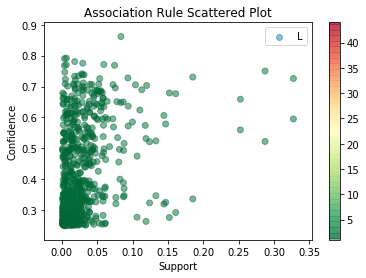

In [5]:
# Association rule scatterplot
x = np.array(df_rules['Support'])
y = np.array(df_rules['Confidence'])
colors = np.array(df_rules['Lift'])

plt.scatter(x, y, c=colors, cmap='RdYlGn_r',alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend('Lift')
plt.title('Association Rule Scattered Plot')
plt.colorbar()
plt.show()

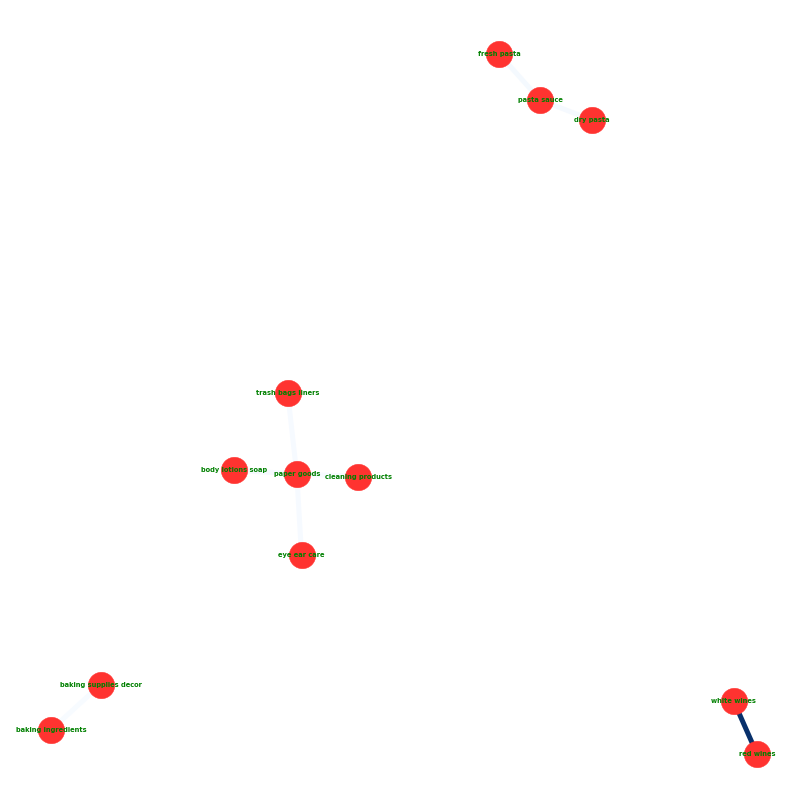

In [6]:
#Association Rules Graph
G=nx.from_pandas_edgelist(df_rules.head(10),"Antecedent","Consequent","Lift")
my_dpi=40
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw(G,with_labels=True,node_color="#ff3330",node_size=2250,edge_color=colors, arrows=False,font_color="Green",font_weight="bold",font_size=12,style="solid",width=9,edge_cmap=plt.cm.Blues)

plt.savefig("nx.png",format="png" )
plt.show()

In [7]:
# Top 10 Marketing Insights of Association by Aisle on Lift

df_rules_by_lift=pd.DataFrame("People who usually buy "+ '<b>' + "{" + df_rules.head(10)['Antecedent'].astype(str) + "}" +'</b>'+" also buy "+'<b>' + "{" + df_rules.head(10)['Consequent'].astype(str) + "}" +'</b>')
pd.set_option("expand_frame_repr", True)
df_rules_by_lift.columns=["Marketing Insights"]

left_aligned_df_lift = df_rules_by_lift.style.set_properties(**{'text-align': 'left'})
left_aligned_df_lift = left_aligned_df_lift.set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])
display(left_aligned_df_lift)


,Marketing Insights
0,People who usually buy {white wines} also buy {red wines}
1,People who usually buy {red wines} also buy {white wines}
2,People who usually buy {fresh pasta} also buy {pasta sauce}
3,People who usually buy {body lotions soap} also buy {paper goods}
4,People who usually buy {pasta sauce} also buy {dry pasta}
5,People who usually buy {dry pasta} also buy {pasta sauce}
6,People who usually buy {eye ear care} also buy {paper goods}
7,People who usually buy {trash bags liners} also buy {paper goods}
8,People who usually buy {baking supplies decor} also buy {baking ingredients}
9,People who usually buy {cleaning products} also buy {paper goods}
